In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import numpy as np
import pandas as pd
import sklearn
import os
import matplotlib.pyplot as plt
import sys
import json
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../')
from src.db_structure import DB_DIR
from src.db_utils import ThingDB

Load instance of DB snapshot:

In [201]:
db_filename = os.path.join(DB_DIR, "default_thingistat_snapshot_1.db")
thing_db = ThingDB(db_filename)

In [202]:
things_df = thing_db.get_table("things")
categories_df = thing_db.get_table("categories")
tags_df = thing_db.get_table("tags")
creators_df = thing_db.get_table("creators")

things_df.dropna() # drop any exlusively None/Null columns of things

,id,name,thumbnail,public_url,added,modified,is_wip,is_featured,is_nsfw,like_count,...,can_comment,added_images_count,likes_count,likes_ids,average_download_count,tags,ancestor_ids,creator_id,accessed,categories


# Preliminary analysis

In [38]:
print("number of things in snapshot", things_df.shape[0])
print("categories in snapshot", categories_df.shape[0])
print("tags in snapshot", tags_df.shape[0])


number of things in snapshot 23254
categories in snapshot 80
tags in snapshot 21623


## Potential independents

### categories

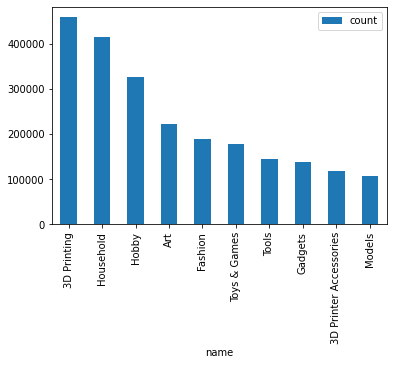

In [222]:
# category counts are independent of the sampling of things in the database
sorted_categories = categories_df.sort_values('count', ascending=False)[:10]
sorted_categories.plot(x='name', y='count', kind='bar')

plt.show()

### tags

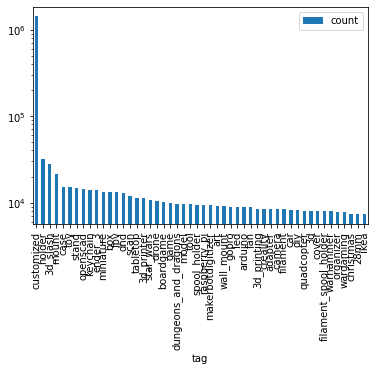

In [159]:
sorted_tags = tags_df.sort_values('count', ascending=False)[:50]
sorted_tags.plot(x='tag', y='count', kind='bar', logy=True)
plt.show()

Too high diversity (21k vs 23k things), highly uniform except for general 
'customized' tag so unlikely to be too informative. 

### Files count

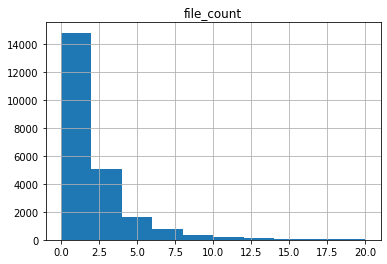

In [83]:
things_df.hist(column="file_count",bins=10, range = (0,20))
plt.show()

### Potential dependents

### like counts

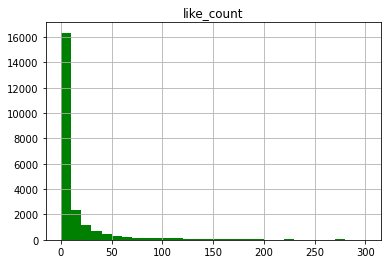

In [74]:
things_df.hist(column="like_count",bins=30, range=(0,300), color='g')
plt.show()

### downloads

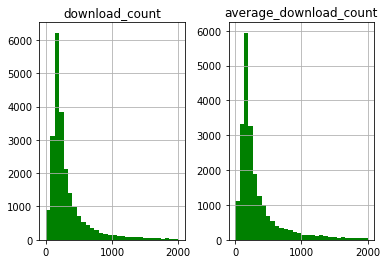

In [75]:
downloads = things_df[['download_count', 'average_download_count']]
downloads.hist(bins=30, range=(0,2000), color='g')
plt.show()

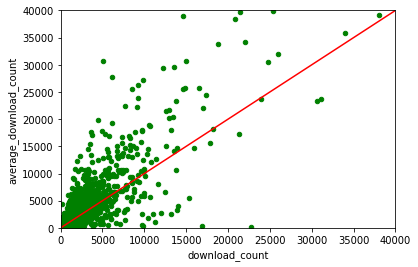

In [77]:
# average download count represents downdloads averaged over all STL files per thingiverse post
things_df.plot(x="download_count", y="average_download_count",kind='scatter',c ='g')
plt.plot(range(0, 40000), range(0,40000), ls='-', color='red')
plt.xlim(0,40000)
plt.ylim(0,40000)
plt.show()

 ^ Minor apparent discrepancy between download count (explicit in the API), and the average number of downloads across STL files per post. Unclear what downloads actually represents (may be numnber of times "download all files" button was clicked).

How does the download metric vary as a function of time?

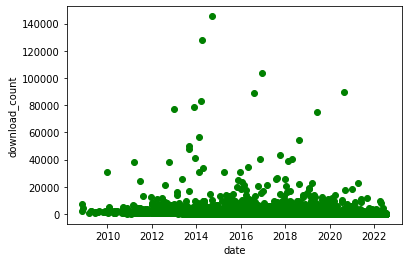

In [92]:
added_series = pd.to_datetime(things_df['added'])

plt.scatter(added_series, things_df['download_count'], c='g')
plt.xlabel('date')
plt.ylabel('download_count')
plt.show()

### view count

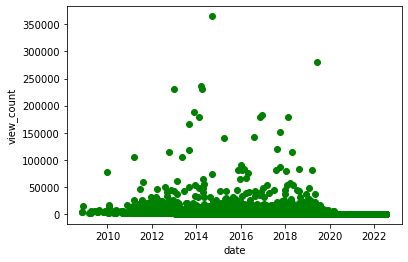

In [93]:
added_series = pd.to_datetime(things_df['added'])

plt.scatter(added_series, things_df['view_count'], c='g')
plt.xlabel('date')
plt.ylabel('view_count')
plt.show()

^ views suddenly disappear from 2020 onwards... limited predictive power for new posts and not useful to predict.

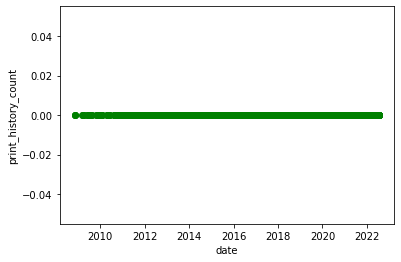

In [95]:
added_series = pd.to_datetime(things_df['added'])

plt.scatter(added_series, things_df['print_history_count'], c='g')
plt.xlabel('date')
plt.ylabel('print_history_count')
plt.show()

# Variance thresholding exploration for Bernoulli features:

In [155]:
from sklearn.feature_selection import VarianceThreshold


is_featured_frequencies = things_df['is_featured'].value_counts()
print(is_featured_frequencies)

X_bernoulli = things_df[['is_wip', 'is_nsfw',
                  'allows_derivatives','is_derivative', 'can_comment']]

feat_sel = VarianceThreshold(0.6*(1-0.6))
feat_sel.fit(X_bernoulli)
X_bernoulli_new = X_bernoulli[X_bernoulli.columns[feat_sel.get_support(indices=True)]]

X_bernoulli_new.head()

Series([], Name: is_featured, dtype: int64)


,is_derivative
0,0
1,0
2,0
3,0
4,1


 ^ suggests I should remove all categorical features except is_derivative.

# Download count estimation with pared down thing features

Starting by removing non-categorical/non-enumerable features like descriptions and instructions. Also being careful to remove features with the problems mentioned above (including those with near zero variance which are all categorical entries except is_derivative).

In [301]:
selected_features = ['like_count', 'collect_count',
                  'comment_count','file_count', 
                  'remix_count','make_count',
                 'root_comment_count', 'is_derivative',
                 'added_images_count']

# convert top 10 category features to one-hot representation
top_10_categories = list(sorted_categories['name'][0:10])
things_df = thing_db.get_table("things")
things_df.dropna() # drop any exlusively None/Null columns of things

# first convert list of single categories to string of category
things_df['categories'] = things_df['categories'].apply(lambda x:json.loads(x)[0])

# fit and transform this column of strings using onehotencoder 
encoder = OneHotEncoder(handle_unknown='ignore', categories=[top_10_categories])

encoder_df = pd.DataFrame(encoder.fit_transform(things_df[['categories']]).toarray())
encoder_df.columns = ["cat:" + ele for ele in top_10_categories]

# join original table and encoder_df
things_df = things_df.join(encoder_df, how='left')

# drop initial categories column
things_df.drop('categories', axis=1, inplace=True)

#create final dataframe
selected_features.extend(list(encoder_df.columns))
x_df = things_df[selected_features]

x_df.head()

,like_count,collect_count,comment_count,file_count,remix_count,make_count,root_comment_count,is_derivative,added_images_count,cat:3D Printing,cat:Household,cat:Hobby,cat:Art,cat:Fashion,cat:Toys & Games,cat:Tools,cat:Gadgets,cat:3D Printer Accessories,cat:Models
0,4,10,0,2,0,0,0,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19,33,0,2,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,1,1,0,1,0,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# feature importance from a Random Forest model of download count

## Variance based feature importance

0.952122539770172 0.6470800841513371
0.8145799145844073


Text(0.5, 0, 'Random Forest Feature Importance (reduction in variance in regression)')

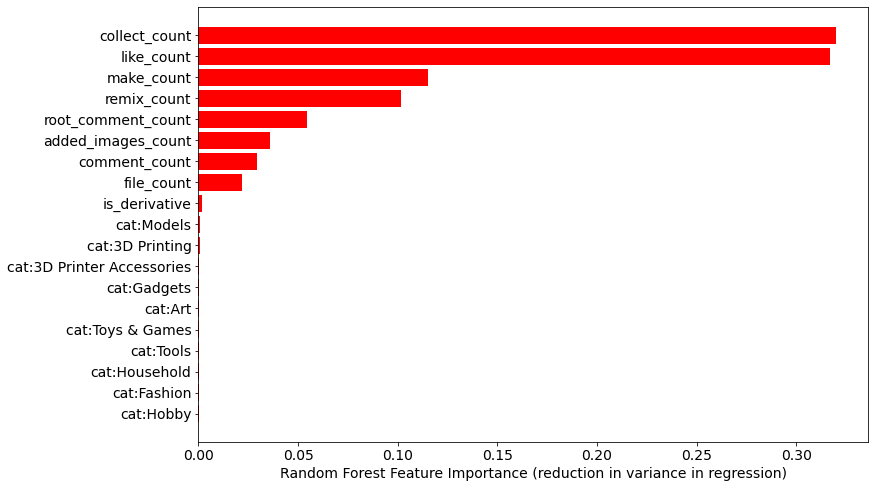

In [319]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

x_train, x_test, y_train, y_test = train_test_split(x_df, things_df.download_count, test_size= 0.25, random_state = 12)

rf = RandomForestRegressor(n_estimators=150, oob_score=True)
rf.fit(x_train, y_train)

# small GS
# grid = {'n_estimators': }


# how well the model is doing
print(rf.score(x_train,y_train), rf.oob_score_)
print(rf.score(x_test,y_test))

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})
sorted_indexes = rf.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_indexes], rf.feature_importances_[sorted_indexes], color='red')
plt.xlabel("Random Forest Feature Importance (reduction in variance in regression)")


^ Actionable parameters for users are to increase comment activity (responses), add more images and files, create a file that is a derivative of another and to post 3D printing related objects or models category. TODO: grid search, add parameters such as  creator followers which will include user popularity into this mix.

## Permutation importance

[-1.64466573e-03 -1.57254719e-04 -1.22826388e-04 -4.37116847e-05
 -1.11353804e-06  4.12457461e-06  6.47045126e-06  1.03800747e-05
  1.65534116e-05  2.26532427e-05  6.54149205e-05  3.29225976e-04
  1.22833406e-02  1.66570541e-02  2.13930394e-02  5.95068714e-02
  7.70562792e-02  1.81009941e-01  2.77530684e-01]
Index(['added_images_count', 'cat:3D Printing', 'cat:Models',
       'cat:Toys & Games', 'cat:Household', 'cat:Tools', 'cat:Hobby',
       'cat:Fashion', 'cat:3D Printer Accessories', 'cat:Gadgets', 'cat:Art',
       'is_derivative', 'file_count', 'remix_count', 'comment_count',
       'root_comment_count', 'make_count', 'collect_count', 'like_count'],
      dtype='object')


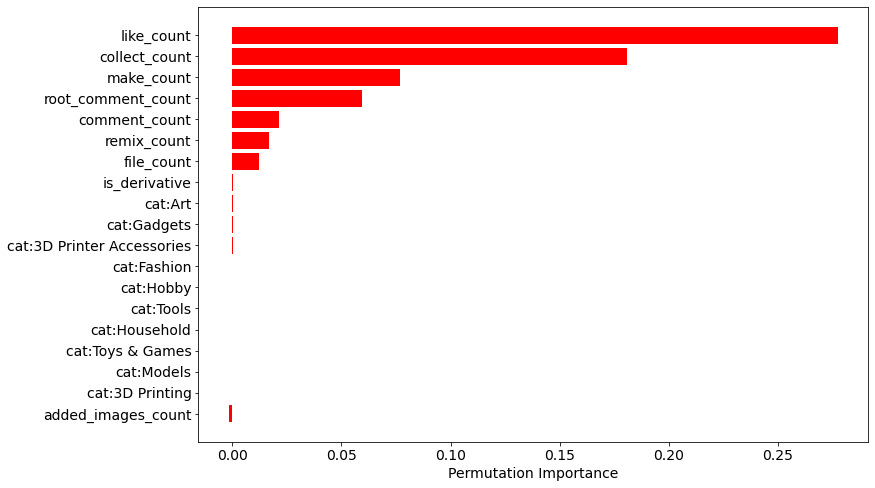

In [318]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, x_test, y_test)

sorted_indexes = perm_importance.importances_mean.argsort()
plt.barh(x_train.columns[sorted_indexes], perm_importance.importances_mean[sorted_indexes], color='red')
plt.xlabel("Permutation Importance")

print(perm_importance.importances_mean[sorted_indexes])
print(x_train.columns[sorted_indexes])

^ Immediately suggests that for the given model most of thse categories, including the 3D printing category when shuffled is less informative that the real data which is a bit surprising.